# Quelques exemples de générations d'articles à travers un 

### Auteur : Boubacar TRAORE

In [6]:
# Changement de la police utilisée et de sa taille
from IPython.core.display import HTML, display
from indexation import change_font
display(HTML(change_font()))

In [7]:
# Ajout du sommaire
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [8]:
# Importation des libraries nécessaires
import os, re
import numpy as np
import pandas as pd

from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

import multiprocessing as mp #paralleliser
import pickle as pkl #pour serialiser

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer #tfidf
from sklearn.metrics.pairwise        import cosine_similarity #similarite cosine
from collections import defaultdict
from num2words   import num2words
from scipy.sparse import coo_matrix

#librairies pour les graphiques
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go

init_notebook_mode(connected=True)

## 1. Indexation

### 1.1. Lecture du corpus entier (avec titre)

In [9]:
# Définition des répertoires où sont stockées nos données
data_dir = 'data'   # Spécification du dossier contenant les articles à parser
cwd = os.getcwd() + "/" + data_dir # cwd contient le chemin d'accès vers le dossier 'data'

Nous allons parcourir tous les articles qui se trouvent dans les dossiers nommés d'après leurs auteurs. Pour cela, nous créons deux listes. La première nommée "documents_infos" qui va contenir les informations disponibles de chaque article (titre et nom de l'auteur) sous forme de dictionnaire et la seconde liste nommée "documents" contient le corps de chaque article stockée sous format texte (str). 

In [10]:
documents_infos, documents  = [], []
for folder in os.listdir(cwd):
    for file in os.listdir(cwd + "/" + folder):
        with open(data_dir + '/' + folder + '/' + file, 'r') as f:
            lines = f.readlines()
            infos = {'title': lines[0].strip(), 'author': folder}
            documents_infos.append(infos)
            documents.append(''.join(lines[1:]))

In [11]:
len(documents)

2500

Nous avons identifié 2500 articles. Essayons maintenant d'afficher le contenu (limité aux 500 premiers caractères) et les informations d'un article aléatoire.

In [12]:
np.random.seed(777)
id_doc = np.random.randint(0,len(documents),1)[0]

In [13]:
documents_infos[id_doc]

{'title': 'Fallout from a scandal involving late allocation of trades at Jardine Fleming was still attracting attention in Hong Kong on Wednesday, but the company escaped further sanctions and said business continued as usual.',
 'author': 'SarahDavison'}

In [14]:
print(documents[id_doc][:500] + '....')

"We've had some redemptions. We've also had some subscriptions," a company spokesman told Reuters. "The business pattern is very much as usual."
Jardine Fleming retained its seat on the executive committee of the domestic industry association, the Hong Kong Investment Funds Association, despite media reports that moves were afoot to knock the company off the committee.
In election results released on Wednesday, Jardine Fleming continues as one of 12 member firms with a representative on the boar....


Tout semble bien stocké. Procédons maintenant au nettoyage des documents de notre corpus. 

### 1.2. Nettoyage des documents

Pour faire une bonne indexation, il est nécessaire de créer un vocabulaire de mots à partir de l'ensemble des documents disponibles. Les mots contenus dans ce vocabulaire doivent être pertinents car le vocabulaire nous servira de référence tout au long du travail. Il faut alors nettoyer chaque document en enlevant les informations redondantes que tous les autres documents possèdent sûrement. Nous allons donc :
* supprimer les ponctuations à cause de leur apparition dans tous les langages
* supprimer les mots qui n'ont qu'un seul caractère car une seule lettre n'est d'aucune utilité pour identifier un document
* remettre tous les mots en miniscule afin d'éviter la sensibilité à la casse des mots du vocabulaire
* transformer les chiffres d'un document en lettre (1000 --> 'one thousand')
* supprimer les stop_words de la langue anglaise contenant les mots usuels utilisés fréquemment dans la langue (ex: my, our, them, etc..)
* faire de la lemmatisation

Il est important de convertir les chiffres présents dans notre corpus en lettre pour qu'il n'y ait pas de différence de traitement de l'algorithme d'indexation entre une requête contenant '21' et une autre contenant 'twenty one'.

La lemmatisation consiste généralement à transformer les mots correctement en utilisant un vocabulaire et une analyse morphologique des mots, visant normalement à supprimer les terminaisons inflexibles uniquement et à rendre la forme de base ou de dictionnaire d'un mot (ex : 'goes', 'went' et 'go' vont compter uniquement pour un seul mot dans le vocabulaire). De plus, nous tenons compte du POS (Part Of Speech) permettant de détecter le contexte dans lequel un mot est utilisé afin d'opérer une meilleure transformation (transformation selon que le mot soit employé comme un verbe, un nom, etc...). En voici un exemple :

In [15]:
# Soit la fonction permettant de détecter le POS d'un mot
def convert_pos(pos):
    if pos.startswith('J'): return wordnet.ADJ
    if pos.startswith('V'): return wordnet.VERB
    if pos.startswith('R'): return wordnet.ADV
    return wordnet.NOUN

In [16]:
sentence_1 = "I was marketing"
sentence_2 = "I am going to the marketing service"
tags_1 = pos_tag(sentence_1.split(' '))
tags_2 = pos_tag(sentence_2.split(' '))

lemmatizer = WordNetLemmatizer() # definir le lemmatiseur
for word, pos in tags_1:
    print(word, ' ----> ', lemmatizer.lemmatize(word, convert_pos(pos)))
print('------------------------------------------')
for word, pos in tags_2:
    print(word, ' ----> ', lemmatizer.lemmatize(word, convert_pos(pos)))

I  ---->  I
was  ---->  be
marketing  ---->  market
------------------------------------------
I  ---->  I
am  ---->  be
going  ---->  go
to  ---->  to
the  ---->  the
marketing  ---->  marketing
service  ---->  service


Comme le mot "marketing", est utilisé comme un verbe dans la première phrase et comme un nom dans la seconde, le lemmatiseur tient compte de cette différence dans la transformation. C'est pourquoi il est très utile de garder les mots dans le bon ordre (afin de préserver le contexte) avant de lemmatiser.

Nous définissons ainsi la fonction de nettoyage finale d'un document entier en tenant compte de tous les points évoqués précédemment.

In [17]:
#Définition des stopwords de la langue anglaise
english_stopwords = stopwords.words('english')
len(english_stopwords) # 179 mots à banir de notre vocabulaire

179

In [18]:
def try_convert_number(word):
    try:
        return num2words(int(word))
    except:
        return word

In [19]:
def clean_document(doc):
    doc   = re.sub(r'\W+', ' ', doc) # Suppression des ponctuations...
    words = doc.lower().strip().split(' ') # tokenisation des mots
    tags  = pos_tag(words)  # Contient les POS de chaque mot dans le document
    lemmatised_words = []
    for word, pos in tags:
        lemmatised_words.append(lemmatizer.lemmatize(word, convert_pos(pos)))
    words = [try_convert_number(word) for word in lemmatised_words if word not in english_stopwords and len(word)>1]
    return ' '.join(words)

In [20]:
cleaned_docs = []
for doc in documents:
    cleaned_docs.append(clean_document(doc))

Voyons voir les résultats sur un document aléatoire. Nous regardons le document original face au document nettoyé.

In [21]:
np.random.seed(24)
id_doc = np.random.randint(0,len(documents),1)[0]

In [22]:
print(documents[id_doc][:500] + '....')

The total was down 75 percent from a similar Federal Communications Commission auction that raised $10.2 billion last May. The average price for a license to provide "personal communications services," or PCS, tumbled more than 90 percent.
PCS technology is expected to turn the wireless phone into a mass-market product, allowing consumers to use different communications services -- such as phone, paging, fax and Internet access -- through a single handheld device.
The drop reflected the flood of....


In [23]:
print(cleaned_docs[id_doc][:500] + '....')

total seventy-five percent similar federal communication commission auction raise ten billion last may average price license provide personal communication service pc tumble ninety percent pc technology expect turn wireless phone mass market product allow consumer use different communication service phone page fax internet access single handheld device drop reflect flood new entrant wireless phone market dearth new money sky high price pay last year pcs sale small slice airwave cover new license....


Le nettoyage semble être bien fait. Les verbes, pronoms, ponctuations ont été supprimés. La lemmatisation est également bien appliquée ('using' devient 'use' dans le 2e paragraphe). Quant aux chiffres, nous voyons bien que 2000 a été remplacé par 'two thousand', ce qui est beaucoup plus pertinent pour la construction du dictionnaire.

### 1.3. Création de l'index

Nous allons commencer par créer un vocabulaire, qui n'est rien d'autre qu'un ensemble (au sens mathématique où il n'y a pas de répétition d'un élément dans l'ensemble) composé de tous les mots contenus dans nos documents nettoyés (cleaned_docs).

In [24]:
# Création du vocabulaire
vocabulary = set()
for doc in cleaned_docs:
    for word in doc.split(' '):
        vocabulary.add(word)

In [25]:
len(vocabulary)

22241

Nous avons un vocabulaire de 22 241 mots et les 5 premiers sont affichés. Place à la créationde l'index grâce à ce vocabulaire.

L'index que nous allons créer n'est rien d'autre qu'un dictionnaire python (ou table de hachage) où :
* la clé de chaque élément du dictionnaire est un mot du vocabulaire précédemment créé
* la valeur associé à chaque clé est une liste de dictionnaire dont la longueur correspond au nombre de documents où apparait la clé de l'index (mot du vocabulaire). Chaque dictionnaire dans cette liste correspond à un document et est composée de 3 éléments : le numéro du document en question où apparait la clé de l'index, le nombre de fois où apparait cette clé dans ce document et les positions auxquelles le mot apparait. 

In [26]:
len(vocabulary)

22241

Passons maintenant à l'indexation.

In [84]:
index = defaultdict(list) #indiquer que chaque valeur associée à une clée est bien une liste
N = len(cleaned_docs)
for i in range(N):
    doc_words = cleaned_docs[i].split(' ')
    nb_words_in_doc = len(doc_words)
    for word in np.unique(doc_words):
        if word in vocabulary:
            idx = [m.start() for m in re.finditer(word, cleaned_docs[i])]
            index[word].append({'num_doc': i, 'nb_fois' : len(idx), 'pos': idx, 'len_doc': nb_words_in_doc})

In [74]:
%%timeit
index = defaultdict(list) #indiquer que chaque valeur associée à une clée est bien une liste
for i in range(len(cleaned_docs)):
    doc_words = cleaned_docs[i].split(' ')
    nb_words_in_doc = len(doc_words)
    for word in np.unique(doc_words):
        if word in vocabulary:
            idx = [m.start() for m in re.finditer(word, cleaned_docs[i])]
            index[word].append({'num_doc': i, 'nb_fois' : len(idx), 'pos': idx, 'len_doc': nb_words_in_doc})

11.2 s ± 52.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


L'index a bien été créé. A titre d'exemple, le mot 'sunny' apparait une fois dans le document 149 à la position 1605, il apparait 2 fois dans le document 1609 aux positions indiqués par la clé 'pos'. Voyons voir ce document qui semble pertienent pour ce mot parmi les autres.

In [31]:
print(documents[1694][:1000] + '....')

The influential index jumped 53.38 points to end at 6054.86 in brisk turnover of 129.3 million shares worth C$2.1 billion ($1.55 billion).
It busted through a previous record of 6018.65 points set on November 28, 1996, partly powered by a Wall Street rally.
Wall Street rose 53.11 points to close at 6762.29 on stronger-than-expected fourth quarter earnings from computer chip maker Intel Corp. Earnings per share jumped to $2.13 from a year-earlier $0.98.
Today's rally in Toronto was also aided by the start of the 1996 pension season, when Canadians rush into last-minute investing in tax sheltered funds before the traditional end-February deadline.
"The RRSP (Registered Retirement Savings Plan) season is beginning," said Midland Walwyn's director of private client investing Dunnery Best.
Fund manager Josef Schachter of Schachter Asset Management said that managers have been cautiously eyeing the market and waiting on the sidelines but have been forced to invest since more fund money will 

Jetons un coup d'oeil sur la répartition des mots de notre index selon leur occurences (barplot)

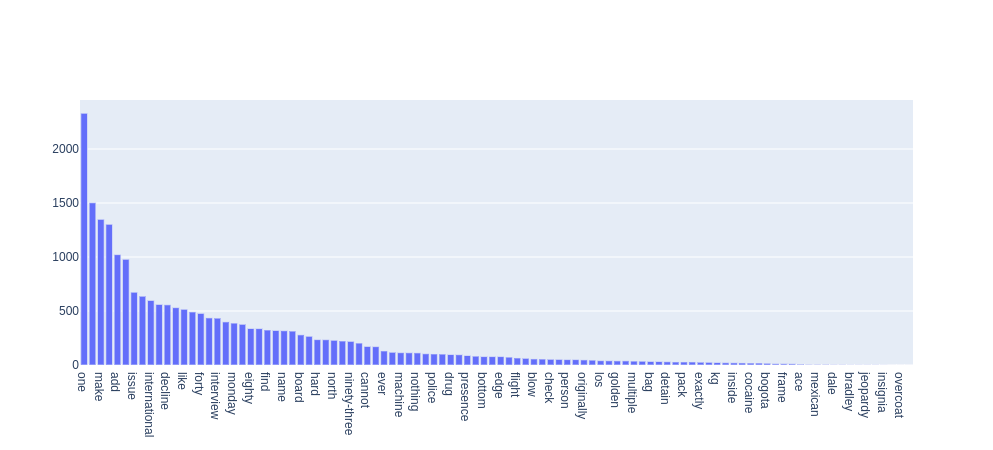

In [32]:
index_series = pd.Series(index)
top_display  = 100 
data  = [go.Bar(
            x= index_series[:top_display].apply(len).sort_values(ascending=False).index,
            y= index_series[:top_display].apply(len).sort_values(ascending=False).values,
)]
iplot(data)

### 1.4. Map Reduce pour la création de l'index

In [33]:
nb_process = mp.cpu_count()
nb_process

8

Notre machine a 8 cpu. Nous allons en utiliser 7 à la fois pour laisser le dernier s'occuper d'autres tâches au même moment. Nous définissons la fonction "**get_doc_index**" qui permet de récupérer l'index construit d'un document. Nous allons ensuite appliquer cette fonction à l'ensemble des documents de notre corpus à l'aide de la fonction "**map**" permettant de faire du multiprocessing. 

In [34]:
def get_doc_index(doc):
    id_doc, document = doc
    index = defaultdict(list)
    doc_words = document.split(' ')
    nb_words_in_doc = len(doc_words)
    
    for word in np.unique(doc_words):
        idx = [m.start() for m in re.finditer(word, document)]
        index[word] = {'num_doc': id_doc, 'nb_fois' : len(idx), 'pos': idx, 'len_doc': nb_words_in_doc}
    return dict(index)

In [36]:
index2 = defaultdict(list) #indiquer que chaque valeur associée à une clée est bien une liste
with mp.Pool(processes = nb_process-1) as pool :
    all_dicts = pool.map(get_doc_index, list(enumerate(cleaned_docs)))
for dico in all_dicts:
    for key in dico.keys():
        index2[key].append(dico[key])

In [35]:
%%timeit
index2 = defaultdict(list) #indiquer que chaque valeur associée à une clée est bien une liste
with mp.Pool(processes = nb_process-1) as pool :
    all_dicts = pool.map(get_doc_index, list(enumerate(cleaned_docs)))
for dico in all_dicts:
    for key in dico.keys():
        index2[key].append(dico[key])

5.15 s ± 528 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [37]:
index['beautiful']

[{'num_doc': 525, 'nb_fois': 1, 'pos': [289], 'len_doc': 272},
 {'num_doc': 1031, 'nb_fois': 1, 'pos': [1772], 'len_doc': 629},
 {'num_doc': 1061, 'nb_fois': 3, 'pos': [384, 3194, 3857], 'len_doc': 601},
 {'num_doc': 1082, 'nb_fois': 1, 'pos': [4084], 'len_doc': 596},
 {'num_doc': 1261, 'nb_fois': 1, 'pos': [518], 'len_doc': 314},
 {'num_doc': 1454, 'nb_fois': 1, 'pos': [111], 'len_doc': 199},
 {'num_doc': 1491, 'nb_fois': 1, 'pos': [111], 'len_doc': 232}]

In [38]:
index2['beautiful']

[{'num_doc': 525, 'nb_fois': 1, 'pos': [289], 'len_doc': 272},
 {'num_doc': 1031, 'nb_fois': 1, 'pos': [1772], 'len_doc': 629},
 {'num_doc': 1061, 'nb_fois': 3, 'pos': [384, 3194, 3857], 'len_doc': 601},
 {'num_doc': 1082, 'nb_fois': 1, 'pos': [4084], 'len_doc': 596},
 {'num_doc': 1261, 'nb_fois': 1, 'pos': [518], 'len_doc': 314},
 {'num_doc': 1454, 'nb_fois': 1, 'pos': [111], 'len_doc': 199},
 {'num_doc': 1491, 'nb_fois': 1, 'pos': [111], 'len_doc': 232}]

Nous avons exactement le même résultat en un temps plus restreint (temps divisé en deux). En effet, malgré l'utilisation de 7 cpu, puisque le temps de calcul sur un seul cpu n'est pas élevé (12 secondes dans l'exemple passé), la différence n'est donc pas énorme. On ne retrouve donc pas un temps divisé par 7 en considérant que le map implique un cout de partage d'informations et de récupération des résultats venant de cpus différents. 

Pour finir cette partie, nous effectuons de la serialisation pour stocker l'index sous forme de fichier dans le disque afin d'éviter de reclaculer l'index à chaque fois qu'on en a besoin (elle servir également pour l'application).

In [43]:
with open('index.pkl', 'wb') as f:
    pkl.dump(index,f)

In [142]:
#pour relire le fichier
#with open('index.pkl', 'rb') as file:
#    pick_index = pkl.load(file)

## 2. Les requêtes

### 2.1. Requête en un mot

Il s'agit simplement d'une requête composée d'un seul mot. Le moteur de recherche nous informe juste du nombre d'articles (documents) où le mot apparait, ou sinon un petit message d'erreur si le mot n'exite pas. Nous allons définir une fonction permettant de répondre à ce problème et montrer deux exemples.

In [30]:
def binary_question(word):
    doc_ids = [doc['num_doc'] for doc in index[word]]
    if len(doc_ids) > 0 : 
        print("'" + word + "'" , 'appears in ', len(doc_ids), 'documents')
        return doc_ids
    return print("'"+ word + "'" , "doesn't exist. Please, try again !")

In [31]:
# Les underscores sont juste là pour ne pas stocker les valeurs de retour de la fonction dont on aura besoin plus tard
_, _, _ = binary_question('dog'), binary_question('warning'), binary_question('violin')

'dog' appears in  72 documents
'warning' appears in  59 documents
'violin' doesn't exist. Please, try again !


### 2.2. Requête en texte libre

Recherche de plusieurs mots successifs dans le corpus. Le moteur retourne le nombre de documents où apparaissent chaque mot individuel de la requête, ensuite le nombre de documents où au moins un mot de la requête apparait (union) et finalement le nombre de documents où tous les mots apparaissent (intersection). Pour cela, nous commençons par définir deux fonctions récursives 'set_union' et 'set_intersection' qui permettent respectivement de trouver tous l'union des numéros de document d'une liste d'ensembles (set) et l'intersection des numéros de document d'une liste d'ensembles (set). En fin de compte, la fonction 'search_text' permet de traiter la requête et d'afficher la réponse.

In [32]:
# Unions et intersections d'une liste d'ensembles de manière récursive.
# ex : [{1,3}, {1,2}, {1,4}], intersection = {1}, union = {1,2,3,4}

def set_intersection(list_of_sets):
    if len(list_of_sets)<=2:
        return set.intersection(list_of_sets[0], list_of_sets[1])
    else:
        return set.intersection(list_of_sets[0], set_intersection(list_of_sets[1:]))
    
def set_union(list_of_sets):
    if len(list_of_sets)<=2:
        return set.union(list_of_sets[0], list_of_sets[1])
    else:
        return set.union(list_of_sets[0], set_union(list_of_sets[1:]))

In [33]:
def search_text(text):
    text = clean_document(text)
    id_docs = []
    word_list = text.split(' ')
    
    if len(word_list) == 1: #Cas où le texte entré n'est qu'un mot
        return binary_question(word_list)
    
    for word in word_list:
        id_docs.append(set(binary_question(word)))
     
    intersection, union = set_intersection(id_docs), set_union(id_docs)
    print("'" + text + "'" , 'has', len(intersection), 'exact matches')
    print("'" + text + "'" , 'has', len(union), 'approximates matches')
    return intersection, union

In [34]:
_ = search_text('the communist party use one single thing')
print('--------')
_ = search_text('the weather is getting worse')

'communist' appears in  218 documents
'party' appears in  321 documents
'use' appears in  1295 documents
'one' appears in  2431 documents
'single' appears in  141 documents
'thing' appears in  678 documents
'communist party use one single thing' has 1 exact matches
'communist party use one single thing' has 2471 approximates matches
--------
'weather' appears in  54 documents
'get' appears in  1136 documents
'bad' appears in  237 documents
'weather get bad' has 14 exact matches
'weather get bad' has 1284 approximates matches


### 2.3. Requête sous forme de phrase avec la prise en compte de l'odre des mots

Cette fois-ci, on tient compte de la succession des mots dans la requête. Le moteur renvoie la liste des documents où les mots de la requête se suivent exactement dans l'ordre.

In [35]:
def queries_index(sentence):
    cleaned_sentence = clean_document(sentence)
    sentence_list    = cleaned_sentence.split(' ')
    intersection, _  = search_text(sentence) #obtenir les documents où tous les mots apparaissent 
    final_docs       = []
    print('---------------------------------------')
    for doc_id in intersection: #on ne s'interesse qu'aux documents contenant à la fois tous les mots de la requête
        _all_sets = [] #contiendra les positions modifiées d'apparition des mots dans le document
        for word in sentence_list:
            for docs in index[word]:
                if docs['num_doc'] == doc_id:
                    word_index = sentence_list.index(word)
                    new_pos=[pos - len(' '.join(sentence_list[:word_index]))-1 if word_index>0 else pos for pos in docs['pos']]
                    _all_sets.append(set(new_pos))
        if len(set_intersection(_all_sets))>0: #intersection des bons décalages trouvé, donc bon document
            final_docs.append(doc_id) 
    print("'" + cleaned_sentence + "'",'appears in exact oder in', len(final_docs), 'documents')
    print('These documents are :', final_docs)

Comme exemple, nous allons tirer une petite expression d'un document aléatoire et tester si l'algorithme arrive à le retrouver.

In [36]:
np.random.seed(0)
id_doc = np.random.randint(0,len(documents),1)[0]
id_doc

1653

In [37]:
documents_infos[id_doc], print(documents[id_doc][:1000])

Covering the quarter before last Thursday's completion of its $7.5 billion acquisition of Turner Broadcasting System, the entertainment group said three hit movies, strong magazine advertising sales helped by the Olympic Games, and good HBO results lifted cash flow to $964 million.
Revenues for the three months ended Sept. 30 were $4.877 billion, up from $4.344 billion a year ago.
Last year's third-quarter cash flow, defined as earnings before interest, taxes, depreciation and amortization, or EBITDA, was $729 million, the company said.
Time Warner, many of whose cable TV and other businesses are co-owned with 25 percent partner U S West Inc. , reported a net loss of $167 million, or 43 cents a share, for the quarter.
Net losses in last year's quarter were $160 million, or 41 cents a share, on 1.5 million more shares outstanding.
Net interest costs were $276 million, up from $259 million in last year's third quarter. Preferred dividends rose to $76 million in the third quarter from $16

({'title': 'Riding rising U.S. cable TV fees, Time Warner Inc said on Wednesday its earnings before heavy debt payments shot up 32 percent in the third quarter, compared with the same three months last year.',
  'author': 'MichaelConnor'},
 None)

Il s'agit d'un article de 'Michael Connor'. Intéressons nous au début du 2e paragraphe faisons une recherche via l'index.

In [38]:
queries_index('Revenues for the three months ended')

'revenue' appears in  370 documents
'three' appears in  1748 documents
'month' appears in  1084 documents
'end' appears in  1923 documents
'revenue three month end' has 111 exact matches
'revenue three month end' has 2379 approximates matches
---------------------------------------
'revenue three month end' appears in exact oder in 3 documents
These documents are : [1653, 1655, 499]


Les quatres mots pertinents se succèdent dans 3 documents exactement. L'indexation a bien permit de retrouver évidemment l'article qui avait été sélectionné au départ dont l'identifiant est **1653**. Vérifions les deux autres documents dont nous n'avions aucune connaissance de l'existence de cet enchainement de mots.

In [39]:
print(documents[1655][:500] + '...')

Covering the quarter before last Thursday's completion of its $7.5 billion acquisition of Turner Broadcasting System, the entertainment group said three hit movies, strong magazine advertising sales helped by the Olympic Games, and good HBO results lifted cash flow to $964 million.
Revenues for the three months ended Sept. 30 were $4.877 billion, up from $4.344 billion a year ago.
Last year's third-quarter cash flow, defined as earnings before interest, taxes, depreciation and amortization, or E...


Effectivement, le 2e paragraphe de l'article **1655** contient exactement ces mots aussi.

In [40]:
print('...' + documents[499][4000:])

...rzowskas, an analyst for First Albany. "You get a lot more conservative."
"After a quarter like this you have to just step back and evaluate," Barzowskas said. "I am not ready to believe they can do what they think they can do at the moment."
But while he slashed his earnings estimates for the foreseeable future, the First Albany analyst maintained his buy rating on the stock at its now severely reduced price.
Shiva said it expected revenue for the three months ending Dec. 28 to be $48 million to $50 million, compared with $57.1 million for the prior quarter, which ended in September. The company reported $35.6 million in revenues for the fourth quarter of 1995.
Shiva said it will report final results for the fourth quarter and year on Jan. 23 after the close of the market.



Egalement, l'avant dernier paragraphe de l'article **499** contient aussi cette succession exacte de mots. L'indexation marche merveilleusement bien :-)

## 3. Ranking

### 3.1. Par nombre d'occurences

In [278]:
def rank_by_ocurrence(query, k=10):
    cleaned_query = clean_document(query)
    words = cleaned_query.split(' ')
    
    scores = pd.Series(np.zeros(len(documents), dtype=int)) #initialiser les scores de tous les documents
   
    for word in words:
        if len(index[word]) > 0: #le mot existe dans l'index
            scores = scores.add(pd.DataFrame(index[word]).set_index('num_doc').nb_fois, fill_value=0)
    
    return scores.sort_values(ascending=False)[:k] #les top k premiers

In [279]:
rank_by_ocurrence(query='The gorvernment is working with all people to build better future')

483     21.0
488     19.0
149     19.0
1172    18.0
1151    18.0
1185    17.0
1192    16.0
1023    16.0
2165    16.0
1154    15.0
dtype: float64

### 3.2. Requête par fréquence normalisée

In [280]:
def rank_by_frequency(query, k=10):
    cleaned_query = clean_document(query)
    words = cleaned_query.split(' ')
    
    scores = pd.Series(np.zeros(len(documents), dtype=int)) #initialiser les scores de tous les documents
    
    for word in words:
        if len(index[word]) > 0: #le mot existe dans l'index
            _df = pd.DataFrame(index[word]).set_index('num_doc').nb_fois
            _df = _df/pd.DataFrame(index[word]).set_index('num_doc').len_doc
            #print(_df.head())
            scores = scores.add(_df, fill_value=0)
    return scores.sort_values(ascending=False)[:k] #les top k premiers

In [281]:
rank_by_frequency(query='The gorvernment is working with all people to build better future')

149     0.081897
483     0.073171
2399    0.054475
488     0.050938
1344    0.050000
1023    0.049080
646     0.046512
1151    0.046036
1172    0.046036
452     0.045872
dtype: float64

### 3.2. Requête par tf_idf

$$\mathrm{tfidf_{i,j}} = \mathrm{tf_{i,j}} \cdot  \mathrm{idf_{i}}$$

La formule utilisée par scikit-learn est : $\mathrm{idf_i} =  1 + \log \frac{|D| + 1}{|\{d_{j}: t_{i} \in d_{j}\}|}$ et $\mathrm{tf_{i,j}}$ est le nombre d'occurences du terme $ t_{i} $ dans le document $d_{j}.$

* $|D|~$ : nombre total de documents dans le corpus ;
* $|\{d_{j} : t_{i} \in d_{j}\}|$ : nombre de documents où le terme <math> t_{i} </math> apparaît (c'est-à-dire <math> n_{i,j} \neq 0</math>).

#### 3.2.1. Requête complexe dans le cas binaire

Ici, nous ne faisons pas de normalisation. Les valeurs de la matrice tf_idf peuvent dépasser 1.

In [256]:
simple_tfidf       = TfidfVectorizer(vocabulary=vocabulary, norm=None)
simple_counter     = CountVectorizer(vocabulary=vocabulary, binary=True) 
tf_idf_mat         = simple_tfidf.fit_transform(cleaned_docs)
simple_counter_mat = simple_counter.fit_transform(cleaned_docs)

In [292]:
def simple_TFIDF(query, k=10):
    
    cleaned_query = clean_document(query) #nettoyer la requete
    
    query_TFIDF = simple_tfidf.transform([query]).toarray() #tfidf de la requete
    
    #produit scalaire simple(somme des tfdfs des mots apparaissants dans la requête)
    relevant_docs = pd.Series(simple_counter_mat.dot(query_TFIDF.T).flatten())
    
    return relevant_docs.sort_values(ascending=False)[:k]

On tire à titre d'exemple une requête du document 759, et on regarde à quel rang le moteur arrive à le classer.

In [293]:
print('...' + documents[759][1500:])

...tional Business Machines Corp. jumped $2.50 to $156.25, both on the New York Stock Exchange, while Intel added $1.75 to $122.50 and Sun Microsystems Inc. gained $2.50 to $59.50, both on Nasdaq.
Still, the fourth quarter has been disappointing to some PC makers, especially those that concentrate heavily on consumer sales.
Last year this time, the release of Microsoft's Windows 95, software that makes PCs easier to use, drew lots of people to computer stores to buy their first PCs. The industry has no such attraction this year.
In fact, analysts said, consumers were putting off computer shopping this Christmas season as the industry prepares new machines based on Intel's upcoming MMX technology. MMX-based machines, slated to be released in early 1997, will feature better video, sound and 3-D graphics.
In late October, computer stocks slid as CompUSA Inc. and other computer retailers reported softening sales heading into the crucial Christmas season.
"There's no question that the quart

In [294]:
simple_TFIDF(query='consumers were putting off computer shopping this Christmas season')

796     16.430138
1985    16.430138
2071    16.430138
530     16.430138
759     16.430138
2059    16.430138
519     16.430138
2349    13.192940
2079    13.192940
2076    13.192940
dtype: float64

Il est classé 1er exaequo, c'est déjà pas mal.

In [284]:
rank_by_frequency('consumers were putting off computer shopping this Christmas season')

420     0.128814
759     0.100304
796     0.100304
766     0.094118
251     0.088235
402     0.075085
511     0.070632
1985    0.069388
795     0.059459
2349    0.052257
dtype: float64

Mais on voit bien que le scoring pra fréquence est mieux, car la page ressort en 2e position.

#### Sans utiliser sklearn (espace vectoriel)

In [85]:
# creation des idfs
idfs=[]
index_series = pd.Series(index)
for i in range(len(vocabulary)):
    idfs.append(np.log((1+len(documents))/(1+len(index_series[i]))))

In [92]:
# construction de la matrice à partir de l'index
vocabulary = list(vocabulary)
def build_M(index_series):
    rows=[]
    columns=[]
    values=[]
    for i in range(len(vocabulary)):
        for j in index_series[vocabulary[i]]:
            columns.append(i)
            rows.append(j['num_doc'])
            values.append(idfs[i]*(j['nb_fois']/j['len_doc']))
    matrice=coo_matrix((values, (rows, columns)), shape=(len(documents), len(vocabulary))).toarray()
    return matrice

In [110]:
A = build_M(index_series)

In [105]:
def queryTFIDF(query):
    query_list = clean_document(query).split(' ')
    values=[]
    columns=[]
    rows=[]
    for i in query_list:
        if i in vocabulary:
            values.append(((query_list.count(i)/len(query_list))*idfs[vocabulary.index(i)]))
            columns.append(vocabulary.index(i))
            rows.append(0)
    vecteur=coo_matrix((values, (rows, columns)), shape=(1, len(vocabulary))).toarray() 
    return vecteur

In [124]:
q = queryTFIDF('consumers were putting off computer shopping this Christmas season').flatten()
q

array([0., 0., 0., ..., 0., 0., 0.])

In [125]:
#score trié par Produit scalaire ()
pd.Series(A.dot(q.T)).sort_values(ascending=False)

759     0.432611
796     0.432611
420     0.402974
2349    0.396700
1985    0.348238
          ...   
1470    0.000000
1471    0.000000
1472    0.000000
1473    0.000000
1249    0.000000
Length: 2500, dtype: float64

#### 3.2.2. Requête complexe avec agregation

In [115]:
#On choisit la somme
def queryBinary(query):
    query_list = clean_document(query).split(' ')
    q = np.zeros(len(vocabulary))
    for word in query_list:
        if word in vocabulary:
            q[vocabulary.index(word)] = 1
    return q

In [126]:
q = queryBinary('consumers were putting off computer shopping this Christmas season').flatten()
q.sum()

6.0

In [127]:
#tri meilleur score par somme
pd.Series(A.dot(q.T)).sort_values(ascending=False)

420     0.528434
796     0.483618
759     0.483618
766     0.380867
251     0.363740
          ...   
1470    0.000000
1471    0.000000
1472    0.000000
1473    0.000000
1249    0.000000
Length: 2500, dtype: float64

In [140]:
### Agregation avec max

def queryArgmax(query):
    query_list = clean_document(query).split(' ')
    l = []
    for i in query_list:
        if i in vocabulary:
            l.append(vocabulary.index(i))
    
    A[:,l].argmax()
    return pd.Series(A[:,l].max(axis=1)).sort_values(ascending=False)

In [141]:
queryArgmax('consumers were putting off computer shopping this Christmas season')

420     0.316397
2349    0.287962
766     0.274521
543     0.258959
508     0.209068
          ...   
1470    0.000000
1471    0.000000
1472    0.000000
1473    0.000000
1249    0.000000
Length: 2500, dtype: float64

Nous voyons que pour es deux méthodes il y a des documents similaires qui apparaissent (420).

#### 3.2.3. Requête avec espace vectoriel sur sklearn

In [297]:
# Initialisation du parser
vect_tfidf     = TfidfVectorizer(vocabulary=vocabulary, norm='l1')
vect_tfidf_mat = vect_tfidf.fit_transform(documents)
vect_tfidf_mat

<2500x22241 sparse matrix of type '<class 'numpy.float64'>'
	with 377783 stored elements in Compressed Sparse Row format>

In [300]:
def vect_TFIDF(query, k=10):
    cleaned_query = clean_document(query) #nettoyer la requete
    
    query_TFIDF = vect_tfidf.transform([query]).toarray() #tfidf de la requete
    
    #similarité cosinus
    relevant_docs = pd.Series(cosine_similarity(query_TFIDF, vect_tfidf_mat).flatten())
    
    return relevant_docs.sort_values(ascending=False)[:k]

In [301]:
vect_TFIDF('consumers were putting off computer shopping this Christmas season')

2349    0.372517
796     0.339876
759     0.337757
2059    0.315469
2071    0.285735
511     0.254087
1985    0.240941
2079    0.239350
519     0.221630
2066    0.205284
dtype: float64

Il est classé 3e ici.